# Bayesian data analysis - beta blocker cross-validation demo

Demonstration of simple model we trust. In this case, cross-validation is not needed and we can get better accuracy using the explicit model.

Import libraries

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
print('Runing on PyMC3 v{}'.format(pm.__version__))

Runing on PyMC3 v3.3


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Comparison of two groups with Binomial

An experiment was performed to estimate the effect of beta-blockers on mortality of cardiac patients (this example is used also in BDA3 chapter 3). A group of patients were randomly assigned to treatment and control groups:

- out of 674 patients receiving the control, 39 died
- out of 680 receiving the treatment, 22 died


In [2]:
d_bin2 = pd.DataFrame(dict(N = np.asarray([674, 680]),
                           y = np.asarray([39,22]),
                           grp2 = np.asarray([0,1])))

d_bin2

,N,grp2,y
0,674,0,39
1,680,1,22


To match the priors used in rstanarm, we specify the prior below:

In [3]:
family = pm.glm.families.Binomial(priors = {'n': np.asarray(d_bin2['N'])})
with pm.Model() as glm1:
    pm.glm.GLM.from_formula(
        'y ~ grp2', data=d_bin2,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=10),
                    grp2=pm.Normal.dist(mu=0, sd=2.5)),
        family=family,
              )
    trace = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [grp2, Intercept]
100%|██████████| 2000/2000 [00:01<00:00, 1200.41it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '4973' (I am process '4974')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '4973' (I am process '4975')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '4974' (I am process '4975')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64

In [4]:
# import patsy
# y, x = patsy.dmatrices('y ~ grp2', d_bin2)
# labels = x.design_info.column_names
# y = np.asarray(y.flatten())
# x = np.asarray(x)

# with pm.Model() as glm1:
#     pm.glm.GLM(x, y, labels=labels, intercept=False,
#                priors=dict(Intercept=pm.Normal.dist(mu=0, sd=10),
#                            grp2=pm.Normal.dist(mu=0, sd=2.5)),
#                family=famil,
#               )
#     trace = pm.sample(1000, tune=1000, cores=4)

In [5]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-2.806813,0.169225,0.004226,-3.136245,-2.482637,1771.109205,1.000127
grp2,-0.600788,0.275768,0.006728,-1.122237,-0.055517,1661.172606,1.000337


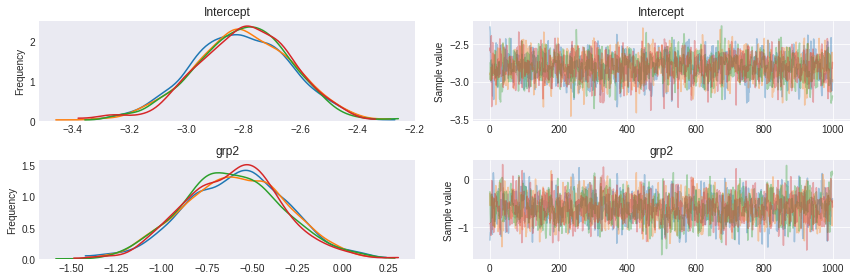

In [6]:
pm.traceplot(trace);

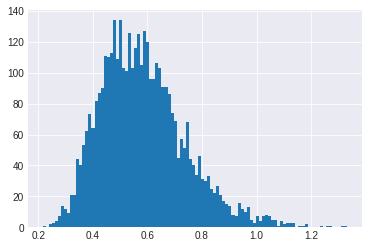

In [7]:
from scipy.stats import logistic
theta1 = logistic.pdf(trace['Intercept'])
theta2 = logistic.pdf(trace['Intercept'] + trace['grp2'])
oddsratio = (theta2/(1-theta2))/(theta1/(1-theta1))
plt.hist(oddsratio, 100);

In [8]:
print('The probability that odds-ratio is less than 1: %.2f'%np.mean(oddsratio<1))

The probability that odds-ratio is less than 1: 0.98


Demonstrate one of the weakneses of cross-validation (same holds for WAIC etc):

In [9]:
d_bin2 =pd.DataFrame(dict(N = 674+680,
                          y = np.hstack((np.ones(39), np.zeros(674-39), 
                                         np.ones(22), np.zeros(680-22))),
                          grp2 = np.hstack((np.zeros(674), np.ones(680)))))

In [10]:
family = pm.glm.families.Binomial()
with pm.Model() as glm1:
    pm.glm.GLM.from_formula(
        'y ~ grp2', data=d_bin2,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=10),
                    grp2=pm.Normal.dist(mu=0, sd=2.5)),
        family=family,
              )
    trace = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [grp2, Intercept]
100%|██████████| 2000/2000 [00:03<00:00, 659.61it/s]


In [11]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-2.798223,0.163412,0.004022,-3.124098,-2.487724,1784.165168,1.002538
grp2,-0.617690,0.269098,0.005695,-1.176816,-0.123398,1852.783153,1.000293


In [12]:
with pm.Model() as glm0:
    pm.glm.GLM.from_formula(
        'y ~ 1', data=d_bin2,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=10)),
        family=family,
              )
    trace0 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept]
100%|██████████| 2000/2000 [00:01<00:00, 1253.00it/s]


In [13]:
pm.loo(trace, model=glm1)

LOO_r(LOO=496.1342336658798, LOO_se=46.639147105268464, p_LOO=1.957121359001377, shape_warn=0)

In [14]:
pm.loo(trace0, model=glm0)

LOO_r(LOO=499.4381345550237, LOO_se=46.88143558540406, p_LOO=1.017570318037798, shape_warn=0)

In [15]:
pm.compare(traces=[trace, trace0],
           models=[glm1, glm0],
           ic='LOO'
        )

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
0,496.13,1.96,0,0.81,46.64,0,0
1,499.44,1.02,3.3,0.19,46.88,4.63,0


The loo function in PyMC3 doesnt provides all the information necessary, use new functions instead:

In [16]:
import loo
df_loo, pointwise = loo.loo(trace, model=glm1)
df_loo.round(1)

Computed from 4000 by 1354 log-likelihood matrix


,Estimate,SE
elpd_loo,-248.1,23.3
p_loo,2.0,0.2
looic,496.1,46.6


In [17]:
pointwise

{'elpd_loo': array([-2.86995341, -2.86995341, -2.86995341, ..., -0.03304082,
        -0.03304082, -0.03304082]),
 'ks': array([-0.27917552, -0.27917552, -0.27917552, ..., -0.17828405,
        -0.17828405, -0.17828405]),
 'looic': array([5.73990683, 5.73990683, 5.73990683, ..., 0.06608163, 0.06608163,
        0.06608163]),
 'p_loo': array([2.36922097e-02, 2.36922097e-02, 2.36922097e-02, ...,
        4.66541616e-05, 4.66541616e-05, 4.66541616e-05])}

In [18]:
df_k = loo.ks_summary(pointwise['ks'])

All Pareto k estimates are good (k < 0.5)


In [19]:
df_loo0, pointwise0 = loo.loo(trace0, model=glm0)
df_loo0.round(1)

Computed from 4000 by 1354 log-likelihood matrix


,Estimate,SE
elpd_loo,-249.7,23.4
p_loo,1.0,0.1
looic,499.4,46.9


In [20]:
df_k0 = loo.ks_summary(pointwise0['ks'])

All Pareto k estimates are good (k < 0.5)


All k<0.5 and we can trust PSIS-LOO result.

Now make pairwise comparison.

In [21]:
comp = loo.compare([pointwise, pointwise0])
comp.round(1)

,elpd_diff,se
m1-m0,-1.7,2.3


> `elpd_diff` is small compared to se, and thus cross-validation is uncertain whether would be significant improvement in predictive performance! To put this in persepective, we have N1=674 and N2=680, and 5.8% and 3.2% deaths, and this is now too weak information for cross-validation.

Simulation study similar to `binom_odds_comparison.R`